# Import and prepare Notebook Environement

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
sys.path.append(os.path.abspath("../../../src/"))

In [3]:
from EmbVector import Vector

## **Models**
## Getting datas
**clean_art mode** : The "Sum" colum of datas is the sum of all word vector from the cleaned article having preprocessing. 

In [4]:
def get_model(is_balanced):
    if is_balanced:
        path = "../../../datas/skipgram_A3316_WS20_E20_B10000_R2000_CTrue.model"
    else:
        path = "../../../datas/skipgram_3284.model"
    return path

In [5]:
datas = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = True), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "clean_art")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
Number of article words not foud : 189
____________________________________________________________________
Getting vectors finished in 46.382880602 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [8]:
X = datas.vectors[['Gene','Variation','Sum']]
Y = pd.get_dummies(datas.vectors["Class"]).values

#X = datas_unbalanced.vectors[['Gene','Variation','Sum']]
#Y = pd.get_dummies(datas_unbalanced.vectors["Class"]).values

In [9]:
print(X['Gene'].shape)
print(X['Variation'].shape)
print(X['Sum'].shape)

(3314,)
(3314,)
(3314,)


## Models : datas concatenated
First we need to split datas to reshape  and clean the shape

In [184]:
X_gene = X["Gene"]
X_var = X["Variation"]
X_sum = X["Sum"]

## **Building the model with Gene, Variation and Sum datas**

In [185]:
X_gene = X_gene.values.reshape(X_gene.shape[0], 1)
X_var = X_var.values.reshape(X_var.shape[0], 1)
X_sum = X_sum.values.reshape(X_sum.shape[0], 1)

In [12]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [186]:
X_gene = convert_to_np_gene(X_gene)
X_var = convert_to_np_var_sum(X_var)
X_sum = convert_to_np_var_sum(X_sum)

In [12]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

print("Y : " + str(Y.shape))

X_gene : (3314, 100)
X_var : (3314, 100)
X_sum : (3314, 100)
Y : (3314, 9)


## Reform the X_train with cleaned shape for 1D

In [214]:
X_concat = np.concatenate((X_gene, X_var, X_sum), axis = 1) 

In [215]:
X_concat.shape

(3314, 300)

In [540]:
X_train, X_test, Y_train, Y_test = train_test_split(X_concat, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 300)
Y_train : (2651, 9)
X_test : (663, 300)
Y_test : (663, 9)


## Over Sampling

In [541]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)

(4128, 300)
(4128, 9)


In [542]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(4128, 300, 1)
(663, 300, 1)


## **Building short model with Gene, Variation and Sum datas**

## **Building CNN model with Gene, Variation and Sum datas**

## Model 1 : CNN 1D

In [506]:
def create_model_cnn():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Conv1D(32, kernel_size=(3), activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))
    return model

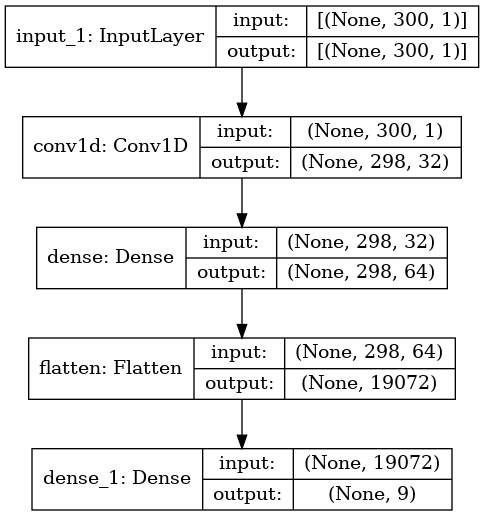

In [543]:
model_cnn = create_model_cnn()
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_cnn, "CNN_W2V_ca.png", show_shapes= True)

## **Training**

## CNN Model

In [544]:
history_cnn = model_cnn.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [545]:
loss, accuracy = model_cnn.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 89.995 %


In [546]:
loss, accuracy = model_cnn.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  66.063 %


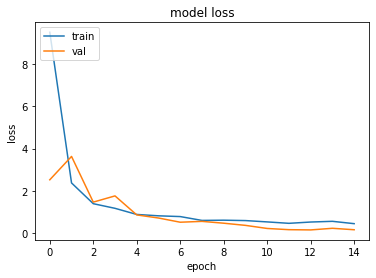

In [547]:
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **Saving models**

In [549]:
model_cnn.save("../../../results/Models/best/best2.model")

2021-10-28 17:00:59.337371: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../../results/Models/best/best2.model/assets


__________________________________

# Clear the Session and delete model

In [539]:
keras.backend.clear_session()
del model_cnn

__________________________________

__________________________________

# **Confusion matrix**

In [293]:
def plot_matrices(model, x_test, y_test):
  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds))) 

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6)) 
  labels = [1,2,3,4,5,6,7,8,9]

  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion') 

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision') 

  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels) 

  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
  
  plt.show()


In [ ]:
#model_cnn = keras.models.load_model("../../../results/Models/best/best2.model")

Log loss: 1.2727287583559719
Accuracy: 0.6606334841628959


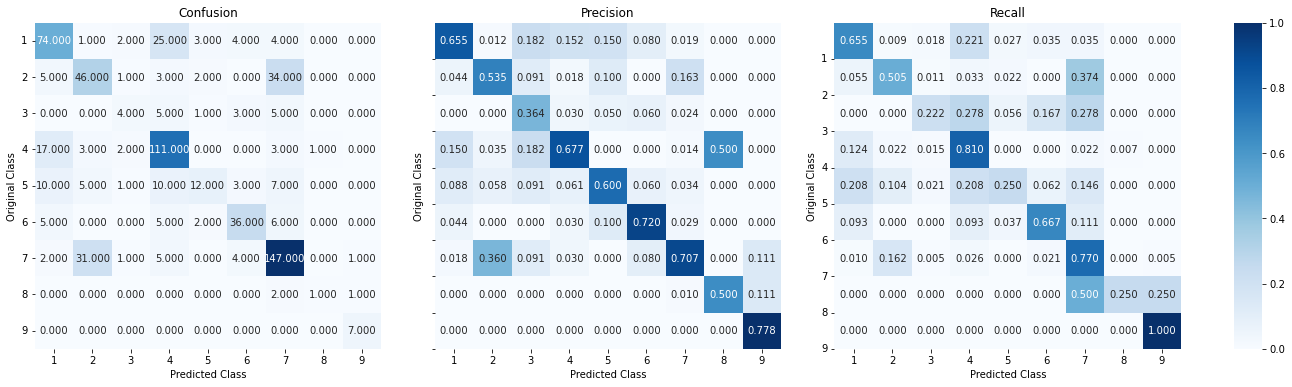

In [548]:
plot_matrices(model_cnn, X_test, Y_test)